Imports

In [28]:
import os
from typing import Generator, List, Tuple

import cv2
import joblib
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from torchvision.datasets import CIFAR10

Constants


In [7]:
MAX_ITERATIONS: int = 10000
RESOLUTION: Tuple[int, int] = (64, 64)

Image pyramid generator, for image scaling

In [8]:
def image_pyramid(image: np.ndarray, scale: float = 1.5, minSize: Tuple[int, int] = RESOLUTION) -> Generator[np.ndarray, None, None]:
    """
    Generates an image pyramid.

    :param image: The original image as a NumPy array.
    :param scale: The scaling factor for resizing the image.
    :param minSize: The minimum size (width, height) at which resizing stops.
    :yield: The resized image as a NumPy array.
    """
    yield image
    while True:
        w: int = int(image.shape[1] / scale)
        h: int = int(image.shape[0] / scale)
        image = cv2.resize(image, (w, h))
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image

Quad Tree implementation

In [9]:
def is_face_in_region(image: np.ndarray,
                      svm: SVC,
                      x: int,
                      y: int,
                      width: int,
                      height: int) -> bool:
    """
    Check if a region potentially contains a face.

    :param image: Input image
    :param svm: Trained SVM classifier
    :param x: X coordinate of top-left corner
    :param y: Y coordinate of top-left corner
    :param width: Width of region
    :param height: Height of region
    :return: True if region may contain a face
    """
    # Extract the region
    region = image[y:y+height, x:x+width]

    # Skip if region is too small
    if region.shape[0] < RESOLUTION[1] or region.shape[1] < RESOLUTION[0]:
        return False

    # Resize region to model's expected resolution
    resized = cv2.resize(region, RESOLUTION)

    # Extract features and predict
    features = extract_hog_features(resized)
    prediction = svm.predict([features])

    return prediction == 1

def quad_tree_detection(image: np.ndarray,
                        svm: SVC,
                        x: int = 0,
                        y: int = 0,
                        width: int = None,
                        height: int = None,
                        min_size: int = 64,
                        depth: int = 0,
                        max_depth: int = 5) -> List[Tuple[int, int, int, int]]:
    """
    Recursively detect faces using a quad tree approach.

    :param image: Input image
    :param svm: Trained SVM classifier
    :param x: X coordinate of the current region
    :param y: Y coordinate of the current region
    :param width: Width of the current region
    :param height: Height of the current region
    :param min_size: Minimum size of regions to check
    :param depth: Current recursion depth
    :param max_depth: Maximum recursion depth
    :return: List of face detections as (x, y, width, height)
    """
    if width is None:
        width = image.shape[1]
    if height is None:
        height = image.shape[0]

    detections = []

    # Check if this region might contain a face
    if is_face_in_region(image, svm, x, y, width, height):
        # If we're at the leaf level or min size, run the sliding window detector
        if depth >= max_depth or width <= min_size or height <= min_size:
            # Run sliding window detection in this promising region
            region = image[y:y+height, x:x+width]
            local_detections = []

            for step_size in [16, 8]:  # Try larger step first, then refine
                for (win_x, win_y, window) in sliding_window(region, step_size, RESOLUTION):
                    if window.shape[0] != RESOLUTION[1] or window.shape[1] != RESOLUTION[0]:
                        continue

                    features = extract_hog_features(window)
                    prediction = svm.predict([features])

                    if prediction == 1:
                        local_detections.append((x + win_x, y + win_y, RESOLUTION[0], RESOLUTION[1]))

            detections.extend(local_detections)
        else:
            # Divide into four quadrants
            half_width = width // 2
            half_height = height // 2

            # Process each quadrant recursively
            detections.extend(quad_tree_detection(image, svm, x, y,
                                               half_width, half_height,
                                               min_size, depth + 1, max_depth))

            detections.extend(quad_tree_detection(image, svm, x + half_width, y,
                                               half_width, half_height,
                                               min_size, depth + 1, max_depth))

            detections.extend(quad_tree_detection(image, svm, x, y + half_height,
                                               half_width, half_height,
                                               min_size, depth + 1, max_depth))

            detections.extend(quad_tree_detection(image, svm, x + half_width, y + half_height,
                                               half_width, half_height,
                                               min_size, depth + 1, max_depth))

    return detections

In [10]:
def sliding_window(image: np.ndarray, stepSize: int, windowSize: Tuple[int, int]) -> Generator[Tuple[int, int, np.ndarray], None, None]:
    """
    Iterates over an image with a sliding window.

    :param image: The image to iterate over as a NumPy array.
    :param stepSize: The step size for moving the window.
    :param windowSize: The size of the window (width, height).
    :yield: The coordinates (x, y) and the extracted patch as a NumPy array.
    """
    for y in range(0, image.shape[0] - windowSize[1] + 1, stepSize):
        for x in range(0, image.shape[1] - windowSize[0] + 1, stepSize):
            yield x, y, image[y:y + windowSize[1], x:x + windowSize[0]]

HOG feature extraction (skimage implementation is slow but works well, CV2 is fast but doesn't work well)

In [11]:
def extract_hog_features(image: np.ndarray,
                         pixels_per_cell: Tuple[int, int] = (8, 8),
                         cells_per_block: Tuple[int, int] = (2, 2),
                         orientations: int = 9) -> np.ndarray:
    """
    Extracts HOG (Histogram of Oriented Gradients) descriptors from an image.

    :param image: The input image as a NumPy array.
    :param pixels_per_cell: The size of each cell in pixels (width, height).
    :param cells_per_block: The number of cells per block (width, height).
    :param orientations: The number of orientation bins for the histograms.
    :return: The HOG feature vector as a NumPy array.
    """
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(image, orientations=orientations,
                      pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block,
                      block_norm='L2-Hys', visualize=True)
    return features

LFW dataset loading (positive class)

In [12]:
def load_lfw_positive_images(target_size: Tuple[int, int] = RESOLUTION) -> Tuple[np.ndarray, int]:
    """
    Loads the LFW dataset, extracts positive images, and resizes them to the target size.

    :param target_size: The target size (width, height) for resizing the images.
    :return: A tuple containing the NumPy array of resized positive images and the count of positive images.
    """
    lfw = fetch_lfw_people(color=True, funneled=True, resize=1.0)
    pos_img: np.ndarray = lfw.images
    pos_cnt: int = pos_img.shape[0]

    pos_resized: np.ndarray = np.array([cv2.resize(img, target_size) for img in pos_img])
    return pos_resized, pos_cnt

In [13]:
positive_images: np.ndarray
positive_count: int
positive_images, positive_count = load_lfw_positive_images(target_size=RESOLUTION)
print(positive_count)

13233


CIFAR-10 dataset loading (negative class)

In [14]:
def load_cifar10_negative_images(data_path: str = './data', target_size: Tuple[int, int] = RESOLUTION) -> Tuple[np.ndarray, int]:
    """
    Loads the CIFAR-10 dataset, resizes images to the target size, and extracts negative images as a single NumPy array.

    :param data_path: Path to download and store the CIFAR-10 dataset.
    :param target_size: The target size (width, height) for resizing the images.
    :return: A tuple containing the NumPy array of resized negative images and their count.
    """
    cifar10_dataset = CIFAR10(
        root=data_path,
        train=True,
        download=True
    )

    neg_img: np.ndarray = np.array([
        cv2.resize(np.array(img), target_size) for img, _ in cifar10_dataset
    ])
    neg_cnt: int = len(neg_img)

    return neg_img, neg_cnt

In [15]:
negative_images: np.ndarray
negative_count: int
negative_images, negative_count = load_cifar10_negative_images()
print(negative_count)

50000


Loading the dataset

In [16]:
def load_dataset(pos_img: np.ndarray,
                 neg_img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load dataset with optimized parallel HOG feature extraction.

    :param pos_img: Array of positive class images.
    :param neg_img: Array of negative class images.
    :return: A tuple containing the feature matrix (data_X) and the label vector (labels_y).
    """
    total_images = len(pos_img) + len(neg_img)
    feature_length = len(extract_hog_features(pos_img[0]))

    data_X = np.zeros((total_images, feature_length), dtype=np.float32)
    labels_y = np.zeros(total_images, dtype=np.int32)

    n_pos = len(pos_img)
    for i, img in enumerate(pos_img):
        data_X[i] = extract_hog_features(img)

    labels_y[:n_pos] = 1

    for i, img in enumerate(neg_img):
        data_X[i + n_pos] = extract_hog_features(img)

    return data_X, labels_y

In [17]:
X: np.ndarray
Y: np.ndarray
X, Y = load_dataset(positive_images, negative_images)
print("Dataset size:", X.shape, Y.shape)

Dataset size: (63233, 1764) (63233,)


In [24]:
if not os.path.exists("model"):
    os.makedirs("model")

filename: str = "model/svm_qt.joblib"

Training the SVC (already trained, can be loaded from the commented line)

In [29]:
scaler: StandardScaler = StandardScaler()
X_scaled: np.ndarray = scaler.fit_transform(X)

In [30]:
# svc: SVC = joblib.load(filename)

svc: SVC = SVC(kernel="linear", max_iter=MAX_ITERATIONS)
svc.fit(X, Y)

joblib.dump(svc, filename)

pred_train: np.ndarray = svc.predict(X)
print("Classification report (training data):")
print(classification_report(Y, pred_train))

/Users/andreipriboi/PycharmProjects/svm_face_detection_sandbox/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


KeyboardInterrupt: 

Non-Maximum Suppression (NMS)

In [20]:
def non_max_suppression(boxes: List[Tuple[int, int, int, int]], overlapThresh: float = 0.3) -> List[Tuple[int, int, int, int]]:
    if len(boxes) == 0:
        return []

    boxes_np = np.array(boxes)
    x1 = boxes_np[:, 0]
    y1 = boxes_np[:, 1]
    x2 = x1 + boxes_np[:, 2]
    y2 = y1 + boxes_np[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    indexes = np.argsort(areas)[::-1]

    picked = []
    while len(indexes) > 0:
        i = indexes[0]
        picked.append(i)

        xx1 = np.maximum(x1[i], x1[indexes[1:]])
        yy1 = np.maximum(y1[i], y1[indexes[1:]])
        xx2 = np.minimum(x2[i], x2[indexes[1:]])
        yy2 = np.minimum(y2[i], y2[indexes[1:]])

        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)

        overlap = (w * h) / areas[indexes[1:]]
        indexes = np.delete(indexes, np.concatenate(([0], np.where(overlap > overlapThresh)[0] + 1)))

    return [boxes[i] for i in picked]

Detection function

In [21]:
def detect_faces_quad_tree(image: np.ndarray,
                          svm: SVC,
                          min_size: int = 64,
                          max_depth: int = 3) -> List[Tuple[int, int, int, int]]:
    """
    Detect faces using the quad tree approach.

    :param image: Input image
    :param svm: Trained SVM classifier
    :param min_size: Minimum size of regions to check
    :param max_depth: Maximum recursion depth
    :return: List of face detections after non-max suppression
    """
    # Multi-scale detection using image pyramid
    all_detections = []

    for im_scaled in image_pyramid(image, scale=1.5, minSize=RESOLUTION):
        scale_factor = image.shape[0] / im_scaled.shape[0]

        # Run quad tree detection on this scale
        detections = quad_tree_detection(im_scaled, svm, min_size=min_size, max_depth=max_depth)

        # Scale the detections back to original image size
        scaled_detections = [
            (int(x * scale_factor),
             int(y * scale_factor),
             int(w * scale_factor),
             int(h * scale_factor)) for x, y, w, h in detections
        ]

        all_detections.extend(scaled_detections)

    # Apply non-maximum suppression to remove overlapping detections
    return non_max_suppression(all_detections, overlapThresh=0.3)

Visualization function

In [26]:
def visualize_face_detections(test_image_path: str, svm: SVC) -> None:
    """
    Visualizes face detections using the quad tree approach.

    :param test_image_path: Path to the test image.
    :param svm: A trained SVC model for face detection.
    """
    test_image = cv2.imread(test_image_path)
    if test_image is not None:
        detections = detect_faces_quad_tree(test_image, svm)

        for (x, y, w, h) in detections:
            cv2.rectangle(test_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
        plt.title("Face Detections (Quad Tree)")
        plt.axis("off")
        plt.show()
    else:
        print("Test image not found.")

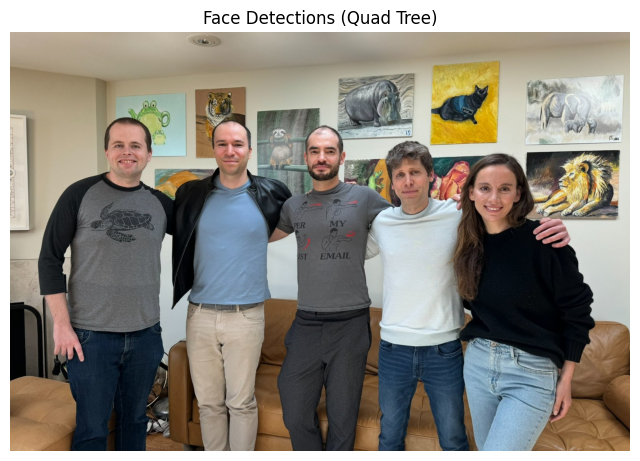

In [27]:
visualize_face_detections("../test_data/test.jpg", svc)